In [16]:
!git clone https://github.com/surmenok/keras_lr_finder.git keras_lr_finder_repo
!mv keras_lr_finder_repo/keras_lr_finder keras_lr_finder
!git clone https://github.com/google/bi-tempered-loss.git
!mv bi-tempered-loss/tensorflow/loss.py loss.py
!rm -r keras_lr_finder_repo bi-tempered-loss 

Cloning into 'keras_lr_finder_repo'...
Cloning into 'bi-tempered-loss'...


In [1]:
import ssl

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, InputLayer, UpSampling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

from loss import _internal_bi_tempered_logistic_loss as bi_tempered_logistic_loss
from utils import (generate_points, mix_cifar, mix_points, points_to_data, get_best_lr)
from plotting import plot_cifar, plot_points, plot_synthetic_results, plot_cifar_results
from tensorflow.keras.callbacks import Callback
from keras_lr_finder.lr_finder import LRFinder

# Bi-tempered logistic loss analysis

### Performance

Standard logistic loss:

In [18]:
%timeit CategoricalCrossentropy(from_logits=False)(np.random.rand(1000, 10).astype(np.float32), np.random.rand(1000, 10).astype(np.float32))

8.81 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Bi-tempered logistic loss:

In [19]:
%timeit bi_tempered_logistic_loss(np.random.rand(1000, 10).astype(np.float32), np.random.rand(1000, 10).astype(np.float32), 0.5, 2.)

34.4 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Bi-tempered logistic loss with both temperatures set to 1:

In [20]:
%timeit bi_tempered_logistic_loss(np.random.rand(1000, 10).astype(np.float32), np.random.rand(1000, 10).astype(np.float32), 1., 1.)

4.23 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Wrapper

In [2]:
class BiTemperedWrapper:
    
    def __init__(self, t1=1., t2=1.):
        self.t1 = t1
        self.t2 = t2
        self.cce = CategoricalCrossentropy(from_logits=True)

    def __call__(self, labels, activations):
        if self.t1 == 1. and self.t2 == 1.:
            return self.cce(labels, activations)
        return bi_tempered_logistic_loss(activations, labels, self.t1,  self.t2)

# Synthetic dataset

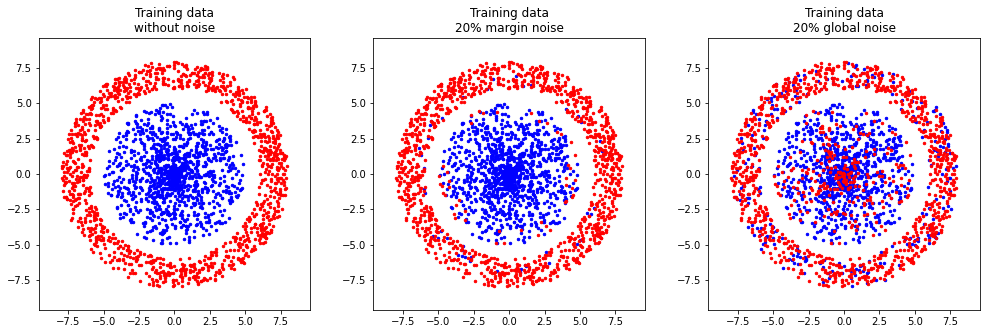

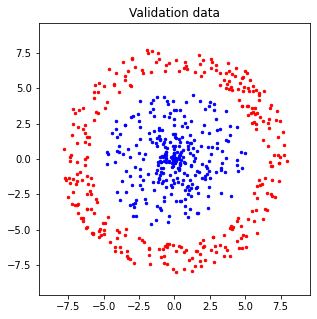

In [3]:
blue_train = generate_points(1200, 0, 5)
red_train = generate_points(1200, 6, 8)
blue_train_margin_noise, red_train_margin_noise = np.copy(blue_train), np.copy(red_train)
blue_train_global_noise, red_train_global_noise = np.copy(blue_train), np.copy(red_train)

mix_points(blue_train_margin_noise, red_train_margin_noise, 4, 7, 0.2)
mix_points(blue_train_global_noise, red_train_global_noise, 0, 8, 0.2)

plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
plt.title("Training data\nwithout noise")
plot_points([blue_train, red_train], 8)

plt.subplot(1, 3, 2)
plt.title("Training data\n20% margin noise")
plot_points([blue_train_margin_noise, red_train_margin_noise], 8)

plt.subplot(1, 3, 3)
plt.title("Training data\n20% global noise")
plot_points([blue_train_global_noise, red_train_global_noise], 8)
plt.show()

plt.figure(figsize=(6, 5))
blue_valid = generate_points(300, 0, 5)
red_valid = generate_points(300, 6, 8)
plt.title("Validation data")
plot_points([blue_valid, red_valid], 8)
plt.show()

In [4]:
X_train, y_train = points_to_data(blue_train, red_train)
X_train_margin, y_train_margin = points_to_data(blue_train_margin_noise, red_train_margin_noise)
X_train_global, y_train_global = points_to_data(blue_train_global_noise, red_train_global_noise)

X_valid, y_valid = points_to_data(blue_valid, red_valid)

In [6]:
def synthetic_model():
    return Sequential([
        InputLayer(input_shape=X_train[0].shape),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(2)
    ])

In [7]:
datasets = {'noise free': (X_train, y_train),
            'margin': (X_train_margin, y_train_margin),
            'global': (X_train_global, y_train_global)}
temp_vals = [(1., 1.), (0.2, 4.0)]
results = {}
for dataset_name, (X_data, y_data) in datasets.items():
    results[dataset_name] = {}
    for temps in temp_vals:
        results[dataset_name][temps] = {}
        model = synthetic_model()
        model.compile(loss=BiTemperedWrapper(*temps), optimizer=Adam(), metrics=['accuracy'])
        history = model.fit(X_data, y_data, validation_data=(X_valid, y_valid), epochs=20)
        results[dataset_name][temps]['model'] = model
        results[dataset_name][temps]['history'] = history.history

Epoch 1/20
75/75 [==============================] - 7s 37ms/step - loss: 0.5864 - accuracy: 0.6112 - val_loss: 0.5043 - val_accuracy: 0.7417
Epoch 2/20
75/75 [==============================] - 1s 13ms/step - loss: 0.4383 - accuracy: 0.7946 - val_loss: 0.3688 - val_accuracy: 0.8600
Epoch 3/20
75/75 [==============================] - 1s 13ms/step - loss: 0.2860 - accuracy: 0.9062 - val_loss: 0.2146 - val_accuracy: 0.9433
Epoch 4/20
75/75 [==============================] - 1s 12ms/step - loss: 0.1631 - accuracy: 0.9692 - val_loss: 0.1322 - val_accuracy: 0.9950
Epoch 5/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0980 - accuracy: 0.9896 - val_loss: 0.0831 - val_accuracy: 0.9900
Epoch 6/20
75/75 [==============================] - 1s 15ms/step - loss: 0.0622 - accuracy: 0.9950 - val_loss: 0.0560 - val_accuracy: 0.9983
Epoch 7/20
75/75 [==============================] - 1s 13ms/step - loss: 0.0448 - accuracy: 0.9992 - val_loss: 0.0438 - val_accuracy: 1.0000
Epoch 8/20
75

Epoch 19/20
75/75 [==============================] - 1s 7ms/step - loss: 0.1244 - accuracy: 0.9608 - val_loss: 0.0491 - val_accuracy: 0.9933
Epoch 20/20
75/75 [==============================] - 1s 7ms/step - loss: 0.1188 - accuracy: 0.9629 - val_loss: 0.0466 - val_accuracy: 0.9950
Epoch 1/20
75/75 [==============================] - 8s 30ms/step - loss: 0.2650 - accuracy: 0.5337 - val_loss: 0.2554 - val_accuracy: 0.5733
Epoch 2/20
75/75 [==============================] - 1s 14ms/step - loss: 0.2508 - accuracy: 0.6208 - val_loss: 0.2401 - val_accuracy: 0.6767
Epoch 3/20
75/75 [==============================] - 1s 15ms/step - loss: 0.2273 - accuracy: 0.7467 - val_loss: 0.2048 - val_accuracy: 0.8467
Epoch 4/20
75/75 [==============================] - 2s 22ms/step - loss: 0.1856 - accuracy: 0.8904 - val_loss: 0.1593 - val_accuracy: 0.9667
Epoch 5/20
75/75 [==============================] - 1s 18ms/step - loss: 0.1484 - accuracy: 0.9400 - val_loss: 0.1268 - val_accuracy: 0.9700
Epoch 6/20
75

75/75 [==============================] - 1s 15ms/step - loss: 0.1955 - accuracy: 0.7987 - val_loss: 0.0828 - val_accuracy: 0.9933
Epoch 18/20
75/75 [==============================] - 1s 18ms/step - loss: 0.1952 - accuracy: 0.7983 - val_loss: 0.0812 - val_accuracy: 0.9950
Epoch 19/20
75/75 [==============================] - 1s 18ms/step - loss: 0.1947 - accuracy: 0.7983 - val_loss: 0.0798 - val_accuracy: 0.9967
Epoch 20/20
75/75 [==============================] - 2s 20ms/step - loss: 0.1941 - accuracy: 0.8000 - val_loss: 0.0771 - val_accuracy: 0.9950


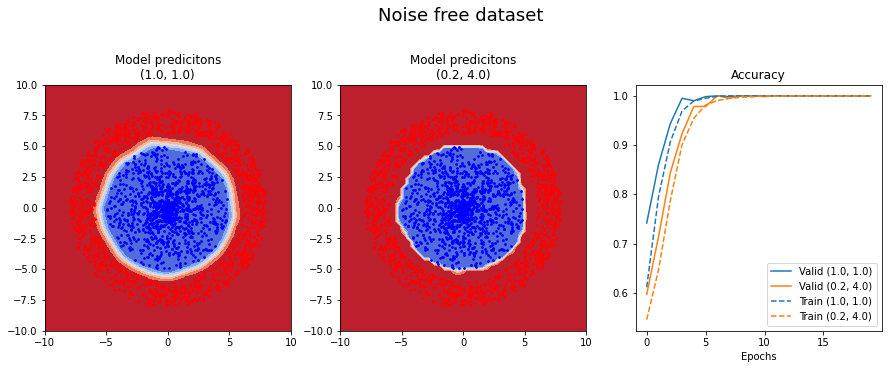

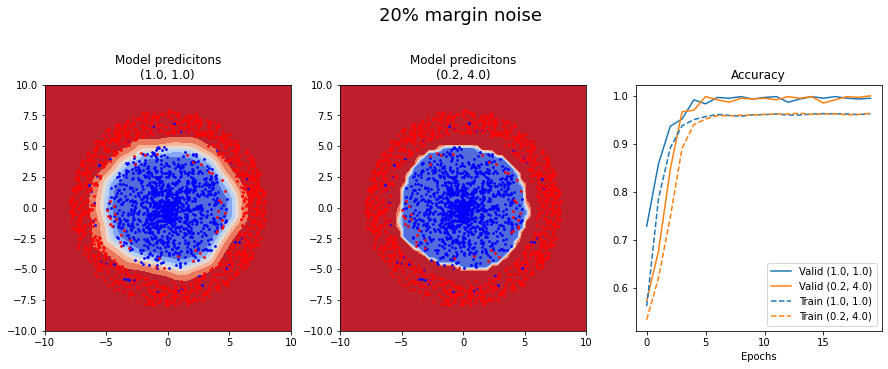

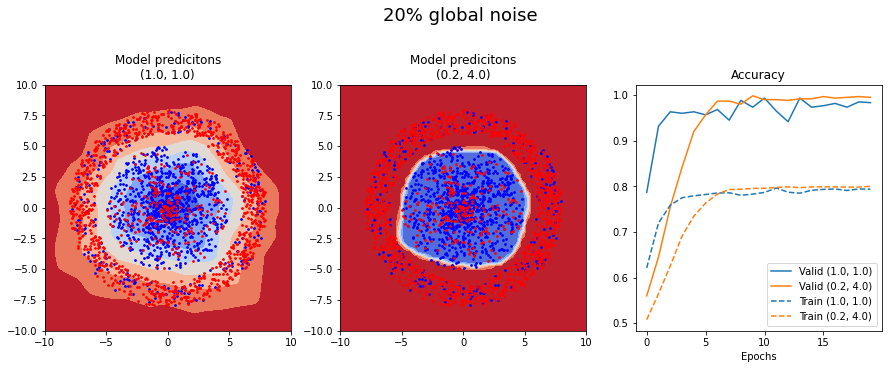

In [8]:
plot_synthetic_results(*datasets['noise free'], results['noise free'], 'Noise free dataset')
plot_synthetic_results(*datasets['margin'], results['margin'], '20% margin noise')
plot_synthetic_results(*datasets['global'], results['global'], '20% global noise')

# CIFAR

In [9]:
ssl._create_default_https_context = ssl._create_unverified_context
(X_train, y_train), (X_valid, y_valid) = cifar10.load_data()

In [10]:
y_train_small_noise, small_noise_idx = mix_cifar(y_train, 0.1) 
y_train_large_noise, large_noise_idx = mix_cifar(y_train, 0.2)

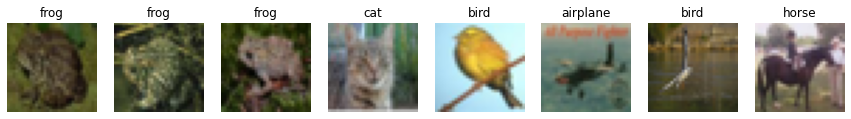

In [11]:
plot_cifar(X_train, y_train)

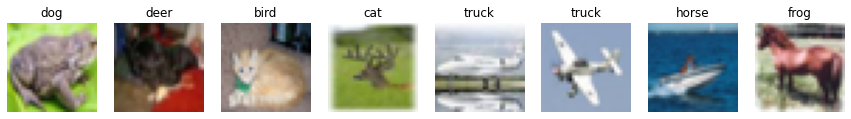

In [12]:
plot_cifar(X_train[small_noise_idx], y_train_small_noise[small_noise_idx])

In [13]:
X_train = resnet50.preprocess_input(X_train)
X_valid = resnet50.preprocess_input(X_valid)

y_train = to_categorical(y_train)
y_train_small_noise = to_categorical(y_train_small_noise)
y_train_large_noise = to_categorical(y_train_large_noise)
y_valid = to_categorical(y_valid)

In [14]:
def cifar_model():
    return Sequential([
        UpSampling2D((7, 7), input_shape=(32, 32, 3)),
        ResNet50(
            include_top=False,
            weights="imagenet",
            classes=10,
            pooling='avg'
        ),
        Flatten(),
        Dense(1024),
        Dense(512),
        Dense(10)
    ])

In [15]:
model = cifar_model()
model.save_weights('model.h5')

In [12]:
datasets = {'noise free': (X_train, y_train),
            'small': (X_train, y_train_small_noise),
            'large': (X_train, y_train_large_noise)}
temp_vals = [(1.0, 1.0), (0.8, 1.2), (0.5, 2.0), (0.2, 4.0)]

In [15]:
best_lr = {}
for temps in temp_vals:
    model.load_weights('model.h5')
    model.compile(loss=BiTemperedWrapper(*temps), optimizer=SGD(momentum=0.8), metrics=['accuracy'])
    
    lr_finder = LRFinder(model)
    lr_finder.find(X_train, y_train, start_lr=1e-10, end_lr=100, batch_size=64)
    lr, loss = get_best_lr(finder)
    best_lr[temps] = lr

    plt.scatter(lr, loss, label=f'Best LR ({round(lr, 4)})')
    plt.title(f"LR finder losses for {temps}")
    plt.legend(loc=3)
    lr_finder.plot_loss()

ResourceExhaustedError:  OOM when allocating tensor with shape[4096,114,114] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/resnet50/pool1_pad/Pad (defined at C:\Users\Wojciech\Documents\training-with-bitempered\keras_lr_finder\lr_finder.py:61) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_19261]

Function call stack:
train_function


In [22]:
results = {}
for dataset_name, (X_data, y_data) in datasets.items():
    results[dataset_name] = {}
    for temps in temp_vals:
        model.load_weights('model.h5')
        results[dataset_name][temps] = {}
        model.compile(loss=BiTemperedWrapper(*temps), optimizer=SGD(learning_rate=best_lr[temps], momentum=0.8), metrics=['accuracy'])
        history = model.fit(X_data, y_data, validation_data=(X_valid, y_valid), batch_size=64, epochs=40, steps_per_epoch=100)

        results[dataset_name][temps]['history'] = history.history
        np.save(f'{dataset_name}_{temps}', history.history)
        model.save_weights(f'{dataset_name}_{temps}.h5')

NameError: name 'cifar_model' is not defined

In [69]:
import os
results={}
for file in os.listdir('histories_lr_learnt'):
    dataset = file.split('_')[0]
    temps = file.split('_')[1][:-4]
    if dataset not in results:
        results[dataset]={}
    results[dataset][temps]=np.load(os.path.join('histories_lr_learnt', file), allow_pickle=True)[()]

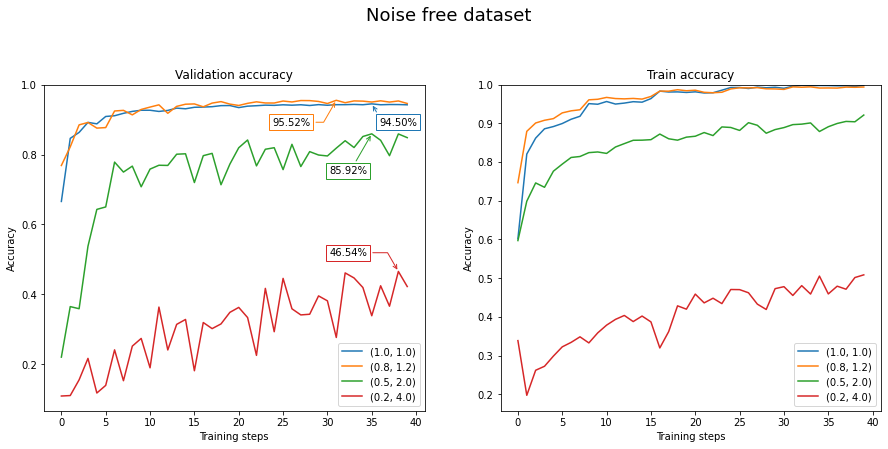

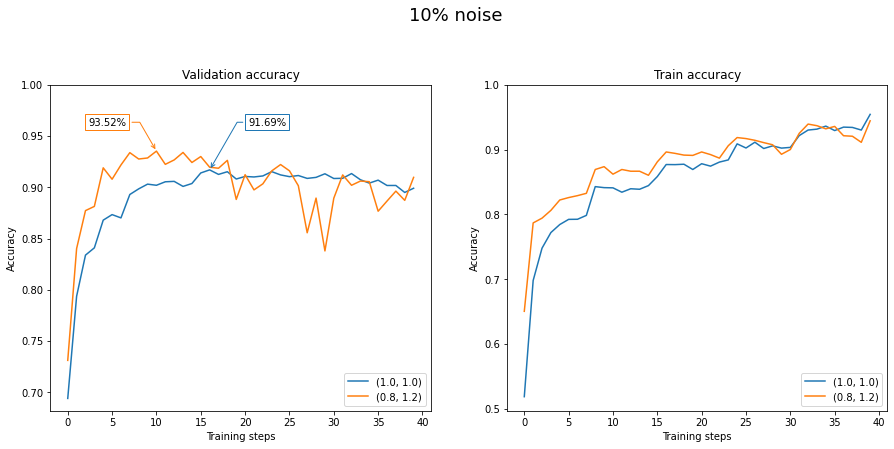

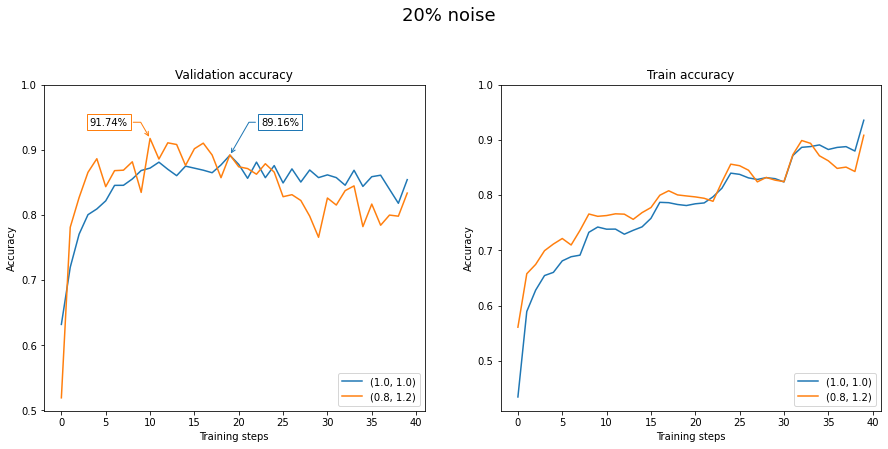

In [78]:
plot_cifar_results(results['noise free'], 'Noise free dataset', max_annotations=[[0.88,0.9],[0.6,0.9],[0.75,0.75],[0.75,0.5]])
plot_cifar_results(results['small'], '10% noise', max_annotations=[[0.52,0.9],[0.1,0.9]])
plot_cifar_results(results['large'], '20% noise', max_annotations=[[0.57,0.9],[0.12,0.9]])